# Importing PySpark and Reading the Dataset

## Importing PySpark

In [453]:
from pyspark.sql import SparkSession, DataFrame

spark = SparkSession.builder.appName("Task02").getOrCreate()

print(spark)

In [454]:
spark.version

'3.5.5'

## Reading the Dataset

In [455]:
file_path = "gold_prices.csv"

df = spark.read.csv(file_path, header=True, inferSchema=True)
df.show(5)

+----------+---------+----------+
|      Date|Buy Price|Sell Price|
+----------+---------+----------+
|2009-08-01|    21.13|     21.19|
|2009-08-02|    21.13|     21.19|
|2009-08-03|    21.13|     21.19|
|2009-08-04|    21.13|     21.19|
|2009-08-05|    21.13|     21.19|
+----------+---------+----------+
only showing top 5 rows



In [456]:
df.describe().show()

+-------+------------------+------------------+
|summary|         Buy Price|        Sell Price|
+-------+------------------+------------------+
|  count|              5565|              5565|
|   mean|  45.5656999101527|46.017667565139305|
| stddev|14.892834946578136|15.353833530564659|
|    min|             21.13|             21.19|
|    max|              89.0|              91.3|
+-------+------------------+------------------+



In [457]:
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Buy Price: double (nullable = true)
 |-- Sell Price: double (nullable = true)



# Generating Samples

In [458]:
from pyspark.sql.functions import lag
from pyspark.sql import Window
from pyspark.ml.feature import VectorAssembler

def generate_samples(dataset: DataFrame, n: int = 10):
  """
  A function to generate a sample dataframe from a dataset.
  :param dataset: The dataframe for sampling.
  :param n: The range of days prior to t, default is 10 days.
  :return: Sample dataframe with n features.
  """

  """
  Collecting the buy price of previous lag_range number of days
    for feature columns of the new sample dataframe
  """
  samples = dataset
  features = []
  window = Window.orderBy("Date")

  for i in range(1, n+1):
    samples = samples.withColumn(
      f"t-{i}",
      lag("Buy Price", i).over(window)
    )
    features.append(f"t-{i}")



  """
  Dropping the "Date" and "Sell Price" columns as well as null
    value rows from the dataframe, while also changing the
    "Buy Price" column name to "t"
  """
  samples = samples.drop("Date", "Sell Price")
  samples = samples.withColumnRenamed("Buy Price", "Current Buy Price")
  samples = samples.dropna()



  """
  Converting the sample dataframe feature columns into a single
    column suitable for machine learning model fit function.
  """
  assembler = VectorAssembler(
    inputCols = features,
    outputCol = "Previous Buy Prices",
  )

  samples = assembler.transform(samples)



  """
  Dropping all the spare columns
  """
  for col in features:
    samples = samples.drop(col)

  return samples

In [459]:
sample_df = generate_samples(df)
sample_df.show(5)

+-----------------+--------------------+
|Current Buy Price| Previous Buy Prices|
+-----------------+--------------------+
|            21.13|[21.13,21.13,21.1...|
|            21.13|[21.13,21.13,21.1...|
|            21.13|[21.13,21.13,21.1...|
|            21.13|[21.13,21.13,21.1...|
|            21.13|[21.13,21.13,21.1...|
+-----------------+--------------------+
only showing top 5 rows



# Training and Predicting

## Splitting the Training and Testing Sets

In [460]:
train_set, test_set = sample_df.randomSplit(weights=[0.7, 0.3], seed=2)

In [461]:
train_set.show(5)

+-----------------+--------------------+
|Current Buy Price| Previous Buy Prices|
+-----------------+--------------------+
|            21.13|[21.13,21.13,21.1...|
|            21.13|[21.13,21.13,21.1...|
|            21.13|[21.13,21.13,21.1...|
|            21.13|[21.13,21.13,21.1...|
|            21.13|[21.13,21.13,21.1...|
+-----------------+--------------------+
only showing top 5 rows



In [462]:
test_set.show(5)

+-----------------+--------------------+
|Current Buy Price| Previous Buy Prices|
+-----------------+--------------------+
|            21.13|[21.13,21.13,21.1...|
|            21.13|[21.13,21.13,21.1...|
|            21.13|[21.13,21.13,21.1...|
|            22.04|[22.04,22.07,22.2...|
|            22.09|[21.13,21.13,21.1...|
+-----------------+--------------------+
only showing top 5 rows



## Training the Model

In [463]:
from pyspark.ml.regression import LinearRegression

lg = LinearRegression(
  featuresCol="Previous Buy Prices",
  labelCol="Current Buy Price",
  solver="l-bfgs",
)

lg_model = lg.fit(train_set)

## Making Predictions

In [464]:
predictions = (lg_model.transform(test_set)
               .withColumnRenamed("prediction", "Predicted Buy Price"))
predictions.show(5)

+-----------------+--------------------+-------------------+
|Current Buy Price| Previous Buy Prices|Predicted Buy Price|
+-----------------+--------------------+-------------------+
|            21.13|[21.13,21.13,21.1...| 21.142049544939837|
|            21.13|[21.13,21.13,21.1...| 21.142049544939837|
|            21.13|[21.13,21.13,21.1...| 21.142049544939837|
|            22.04|[22.04,22.07,22.2...| 22.036285044242522|
|            22.09|[21.13,21.13,21.1...| 21.142049544939837|
+-----------------+--------------------+-------------------+
only showing top 5 rows



# Evaluating the Model

In [465]:
def evaluate_model(dataset: DataFrame):
  """
  A function to evaluate the model performance based on a given dataset.
  :param dataset: The dataframe for evaluation.
  :return: Dictionary of evaluation results using different metrics.
  """

  evaluation = lg_model.evaluate(dataset)

  metrics = {
    "Root Mean Squared Error": evaluation.rootMeanSquaredError,
    "Mean Squared Error": evaluation.meanSquaredError,
    "R2": evaluation.r2,
    "Mean Absolute Error": evaluation.meanAbsoluteError,
    "Explained Variance": evaluation.explainedVariance,
    "R2 Adjusted": evaluation.r2adj,
  }

  max_len = 24

  for metric in metrics.keys():
    print(f"{metric:<{max_len}}: {metrics.get(metric):.4f}")

  return metrics

## On the Training Set

In [466]:
train_evaluation = evaluate_model(train_set)

Root Mean Squared Error : 0.3067
Mean Squared Error      : 0.0940
R2                      : 0.9996
Mean Absolute Error     : 0.1396
Explained Variance      : 227.2342
R2 Adjusted             : 0.9996


## On the Testing Set

In [467]:
test_evaluation = evaluate_model(test_set)

Root Mean Squared Error : 0.3138
Mean Squared Error      : 0.0985
R2                      : 0.9995
Mean Absolute Error     : 0.1418
Explained Variance      : 205.8075
R2 Adjusted             : 0.9995


# Illustration Charts

## Line Chart

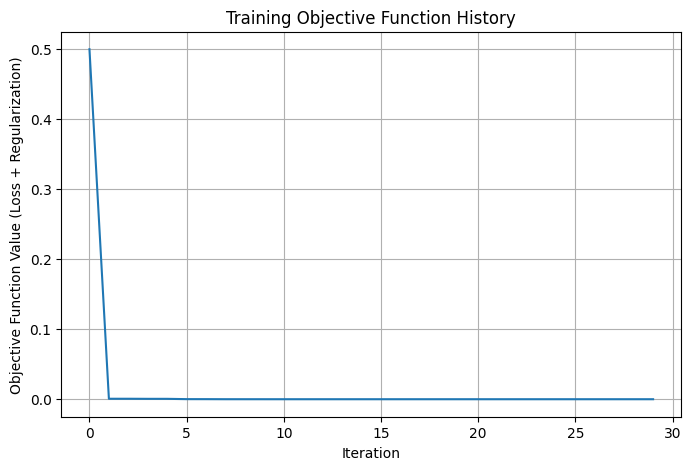

In [468]:
import matplotlib.pyplot as plt

loss_history = lg_model.summary.objectiveHistory

if loss_history:
  plt.figure(figsize=(8, 5))
  plt.plot(loss_history)
  plt.title('Training Objective Function History')
  plt.xlabel('Iteration')
  plt.ylabel('Objective Function Value (Loss + Regularization)')
  plt.grid(True)
  plt.show()

## Bar Chart

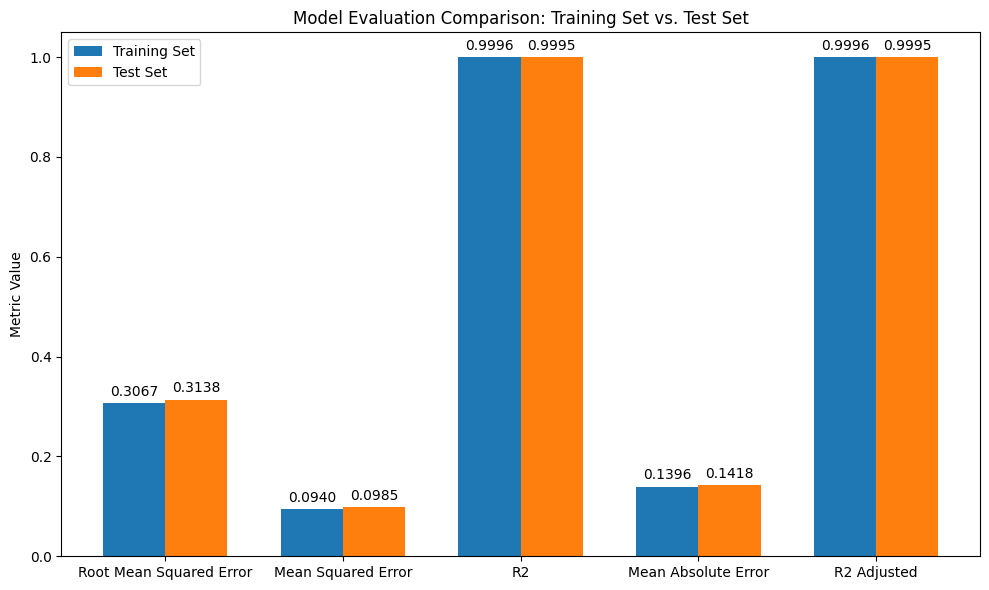

In [469]:
import numpy as np

train_evaluation_copy = train_evaluation.copy()
test_evaluation_copy = test_evaluation.copy()

train_var = train_evaluation_copy.pop("Explained Variance")
test_var = test_evaluation_copy.pop("Explained Variance")

evaluation_metrics = train_evaluation_copy.keys()

x = np.arange(len(evaluation_metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2,
                train_evaluation_copy.values(),
                width,
                label='Training Set')
rects2 = ax.bar(x + width/2,
                test_evaluation_copy.values(),
                width,
                label='Test Set')

# Add some text for labels, title and axes ticks
ax.set_ylabel('Metric Value')
ax.set_title('Model Evaluation Comparison: Training Set vs. Test Set')
ax.set_xticks(x)
ax.set_xticklabels(evaluation_metrics)
ax.legend()

# Optional: Add labels on top of bars for clarity
ax.bar_label(rects1, padding=3, fmt='%.4f')
ax.bar_label(rects2, padding=3, fmt='%.4f')

# Adjust the layout to prevent labels from overlapping
fig.tight_layout()
plt.show()

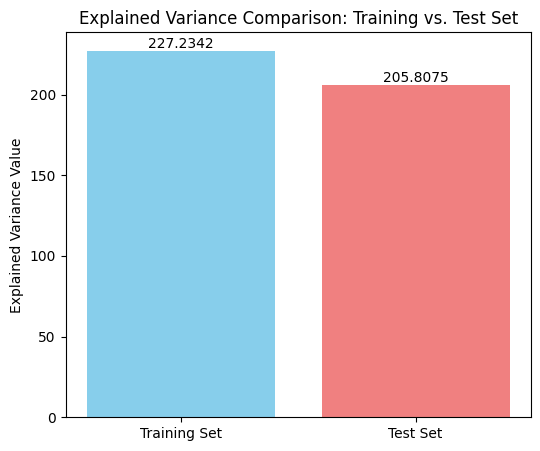

In [470]:
metric_name = "Explained Variance"

sets = ['Training Set', 'Test Set']
values = [train_var, test_var]

plt.figure(figsize=(6, 5))
bars = plt.bar(sets, values, color=['skyblue', 'lightcoral'])

plt.ylabel(f'{metric_name} Value')
plt.title(f'{metric_name} Comparison: Training vs. Test Set')
plt.bar_label(bars, fmt='%.4f')

plt.show()